In [16]:
import torchhd
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from functools import partial
from scipy.stats import norm

In [17]:
import sys
sys.path.append('../')
from shared_code.helpers import similarity_func_partial, prob_corr

In [18]:
VSA_TYPES = ['FHRR', 'BSC', 'MAP', 'HRR']
VSA_TYPES = ['BSC', 'MAP']#, 'HRR'] # FHRR bundling is extremely slow compared to the others
DIMENSIONS = [2**i for i in range(8, 14)]
# DIMENSIONS = [2**i for i in range(8, 12)]
# BUNDLE_SIZES = list(range(2, 10, 1))
BUNDLE_SIZES = list(range(2, 300, 2))
# BUNDLE_SIZES = list(range(2, 100, 2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    torch.cuda.empty_cache()

batches = 5
item_memory_size = 10_000
MAX_BUNDLE_SIZE = BUNDLE_SIZES[-1]

# Evaluating non-normalized capacity of HD vectors

In [19]:
prob_correct_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)
acc_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)

for vsa_type_idx in tqdm(range(len(VSA_TYPES)), disable=True):
  vsa_type = VSA_TYPES[vsa_type_idx]
  print(f'vsa type: {vsa_type}')
  similarity_func = partial(similarity_func_partial, vsa_type)

  for batch in tqdm(range(batches), disable=False):
        # perc_corr_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
        # print(f'iteration: {batch + 1}')

        for d_idx in tqdm(range(len(DIMENSIONS)), disable=True):
            dim = DIMENSIONS[d_idx]
            item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

            # Sample MAX_BUNDLE_SIZE vectors from item memory for experiment
            random_indices = torch.randperm(item_memory_size)[:MAX_BUNDLE_SIZE]
            experiment_to_bundle_vectors = item_memory[random_indices]

            for k_idx in range(len(BUNDLE_SIZES)):
                k = BUNDLE_SIZES[k_idx]

                # sample k vectors from item memory and bundle them (non-sequential)
                to_bundle_vectors = experiment_to_bundle_vectors[:k]

                bundle_vector = torchhd.multiset(to_bundle_vectors) # THIS IS NOT NORMALIZED for MAP

                # find the k nearest vectors to bundle
                similarities = similarity_func(bundle_vector, item_memory)
                k_nearest_vectors_idx = torch.topk(similarities, k, largest=True).indices

                # check how many of the k nearest vectors are correct
                num_correct = np.intersect1d(k_nearest_vectors_idx.cpu().numpy(), random_indices.cpu().numpy()).shape[0]
                TP = num_correct
                FP = k - num_correct
                TN = item_memory_size - k - FP
                FN = k - TP

                # perc_corr_array[d_idx, k_idx] = num_correct / k
                prob_correct_tensor[d_idx, k_idx, vsa_type_idx, batch] = num_correct / k
                acc_tensor[d_idx, k_idx, vsa_type_idx, batch] = (TP + TN) / (TP + TN + FP + FN) 
        
        # prob_correct_tensor[:, :, vsa_type_idx, batch] = perc_corr_array
   
# compute mean and std over batches
prob_correct_mean = torch.mean(prob_correct_tensor, dim=3)
acc_mean = torch.mean(acc_tensor, dim=3)
prob_correct_std = torch.std(prob_correct_tensor, dim=3)
acc_std = torch.std(acc_tensor, dim=3)

# theoretical_prob_correct = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES))

# for vsa_type_idx in tqdm(range(len(VSA_TYPES)), disable=True):
#   vsa_type = VSA_TYPES[vsa_type_idx]
#   print(f'vsa type: {vsa_type}')

#   for d_idx in tqdm(range(len(DIMENSIONS)), disable=True):
#     dim = DIMENSIONS[d_idx]
#     for k_idx in range(len(BUNDLE_SIZES)):
#       k = BUNDLE_SIZES[k_idx]
#       theoretical_prob_correct[d_idx, k_idx, vsa_type_idx] = prob_corr(k, item_memory_size, dim, vsa_type)

vsa type: BSC


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


vsa type: MAP


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


### Line plots for each vsa type

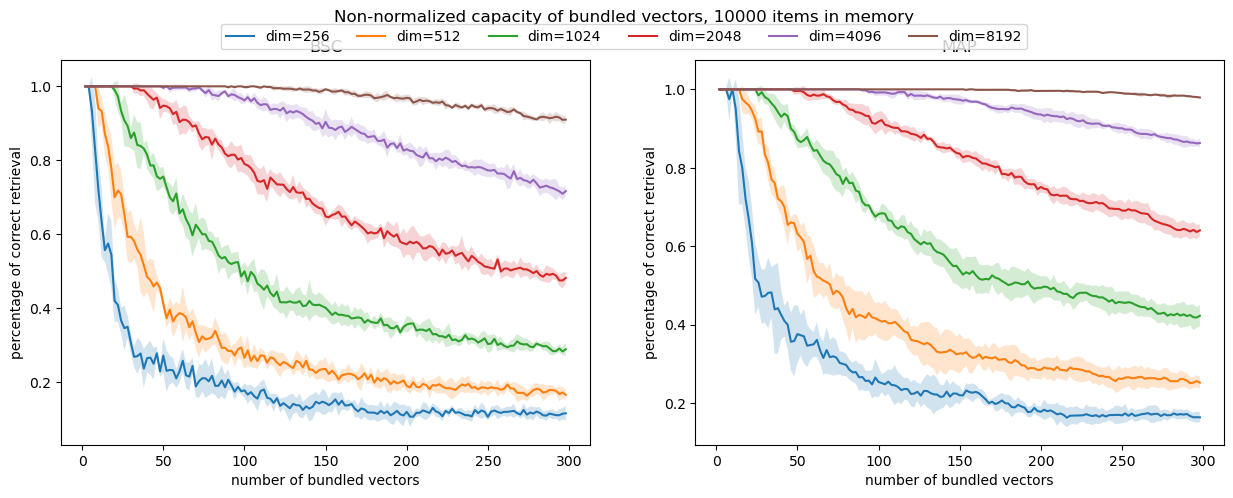

In [40]:
MAX_BUNDLE_SIZE_IDX = len(BUNDLE_SIZES)

fig, ax = plt.subplots(nrows=math.ceil(len(VSA_TYPES)/2), ncols=2, figsize=(15, 5 * ((len(VSA_TYPES))//2)))
if len(VSA_TYPES) <= 2:
    # if there is only one row, ax is a 1D array, so we need to reshape it to 2D for the loop to work
    ax = ax.reshape(1, -1)

fig.suptitle(f'Non-normalized capacity of bundled vectors, {item_memory_size} items in memory')
# upper margin looks too small, so we make it larger

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = vsa_type_idx // 2
    col = vsa_type_idx % 2
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        # ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], acc_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        # ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], theoretical_prob_correct[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'theoretical for dim={DIMENSIONS[dim_idx]}', linestyle='--', color=f'C{dim_idx}')
        ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - prob_correct_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + prob_correct_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
        # ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], acc_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - acc_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], acc_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + acc_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
    ax[row, col].set_title(vsa_type)
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('percentage of correct retrieval')
# Create a single legend for the top plot
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .965))

plt.show()    
# fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

In [ ]:
# MAX_BUNDLE_SIZE_IDX = len(BUNDLE_SIZES)

# fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
# fig.suptitle(f'Non-normalized capacity of bundled vectors, {item_memory_size} items in memory')

# for vsa_type_idx in range(len(VSA_TYPES)):
#     vsa_type = VSA_TYPES[vsa_type_idx]
#     row = (vsa_type_idx+1) // 2 - 1
#     col = vsa_type_idx % 2
#     for dim_idx in range(len(DIMENSIONS)):
#         ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
#         ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - prob_correct_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + prob_correct_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
#     ax[row, col].set_title(vsa_type)
#     ax[row, col].set_xlabel('number of bundled vectors')
#     ax[row, col].set_ylabel('percentage of correct retrieval')
# fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

### Results

We notice that the Non-normalized capacity heavily depends on the dimensionality. We also observe that a decent amount of HD vectors can be retrieved from a bundled set relative to the dimensions used.

### Heatmaps for each vsa type

In [ ]:
# fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
# fig.suptitle(f'Non-normalized capacity of bundled vectors, {item_memory_size} items in memory')
# for vsa_type_idx in range(len(VSA_TYPES)):
#     vsa_type = VSA_TYPES[vsa_type_idx]
#     row = (vsa_type_idx +1) // 2 - 1
#     col = vsa_type_idx % 2
#     ax[row, col].set_title(vsa_type)
#     ax[row, col] = sns.heatmap(prob_correct_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//10, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//10], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'percentage of correct retrieval'})
#     ax[row, col].set_xlabel('number of bundled vectors')
#     ax[row, col].set_ylabel('dimensionality')


## First vector similarity study using non-sequentially bundled HD vectors

In [ ]:
# similarity to first vector
sim_first_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)
sim_random_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)
# probability of retrieval of first vector
retrieval_first_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)

for vsa_type_idx in tqdm(range(len(VSA_TYPES)), disable=True):
  vsa_type = VSA_TYPES[vsa_type_idx]
  print(f'vsa type: {vsa_type}')
  similarity_func = partial(similarity_func_partial, vsa_type)
  
  for batch in tqdm(range(batches), disable=False):
      # sim_first_vector_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
      # retrieval_first_vector_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
      # print(f'iteration: {batch + 1}')

      for d_idx in tqdm(range(len(DIMENSIONS)), disable=True):
          dim = DIMENSIONS[d_idx]
          item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)
          r_vecs = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)[0]
          # bind all vectors in item memory to r_vecs
          item_memory = torchhd.bind(item_memory, r_vecs)

          # sample MAX_BUNDLE_SIZE vectors from item memory
          random_indices = torch.randperm(item_memory_size)[:MAX_BUNDLE_SIZE]
          experiment_to_bundle_vectors = item_memory[random_indices]
          first_vector = experiment_to_bundle_vectors[0]
          random_vector = torchhd.random(1, dim, vsa=vsa_type, device=device)[0]

          for k_idx in range(len(BUNDLE_SIZES)):
              k = BUNDLE_SIZES[k_idx]

              # sample k vectors from item memory and bundle them (non-sequential)
              to_bundle_vectors = experiment_to_bundle_vectors[:k]

              bundle_vector = torchhd.multiset(to_bundle_vectors)
              
              # add similarity of first vector to bundle to array
              # sim_first_vector_array[d_idx, k_idx] = similarity_func(first_vector, bundle_vector)
              sim_first_vector_tensor[d_idx, k_idx, vsa_type_idx, batch] = similarity_func(first_vector, bundle_vector)
              sim_random_vector_tensor[d_idx, k_idx, vsa_type_idx, batch] = similarity_func(random_vector, bundle_vector)

              # find the k nearest vectors to bundle
              similarities = similarity_func(bundle_vector, item_memory)
              k_nearest_vectors_idx = torch.topk(similarities, k, largest=True).indices

              # check if the first vector is in the k nearest vectors
              # retrieval_first_vector_array[d_idx, k_idx] = 1 if random_indices[0] in k_nearest_vectors_idx else 0
              retrieval_first_vector_tensor[d_idx, k_idx, vsa_type_idx, batch] = 1 if random_indices[0] in k_nearest_vectors_idx else 0

      # sim_first_vector_tensor[:, :, vsa_type_idx, batch] = sim_first_vector_array
      # retrieval_first_vector_tensor[:, :, vsa_type_idx, batch] = retrieval_first_vector_array

# compute mean and std over batches
sim_first_vector_mean = torch.mean(sim_first_vector_tensor, dim=3)
sim_first_vector_std = torch.std(sim_first_vector_tensor, dim=3)

sim_random_vector_mean = torch.mean(sim_random_vector_tensor, dim=3)
sim_random_vector_std = torch.std(sim_random_vector_tensor, dim=3)

retrieval_first_vector_mean = torch.mean(retrieval_first_vector_tensor, dim=3)
retrieval_first_vector_std = torch.std(retrieval_first_vector_tensor, dim=3) # is this relevant?

# theoretical_prob_correct = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES))

# for vsa_type_idx in tqdm(range(len(VSA_TYPES)), disable=True):
#   vsa_type = VSA_TYPES[vsa_type_idx]
#   print(f'vsa type: {vsa_type}')
#   similarity_func = partial(similarity_func_partial, vsa_type)

#   for d_idx in tqdm(range(len(DIMENSIONS)), disable=True):
#     dim = DIMENSIONS[d_idx]
#     for k_idx in range(len(BUNDLE_SIZES)):
#       k = BUNDLE_SIZES[k_idx]
#       theoretical_prob_correct[d_idx, k_idx, vsa_type_idx] = prob_of_error(k, item_memory_size, dim, vsa_type)

vsa type: BSC


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


vsa type: MAP


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


vsa type: HRR


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


### Line plots for each vsa type

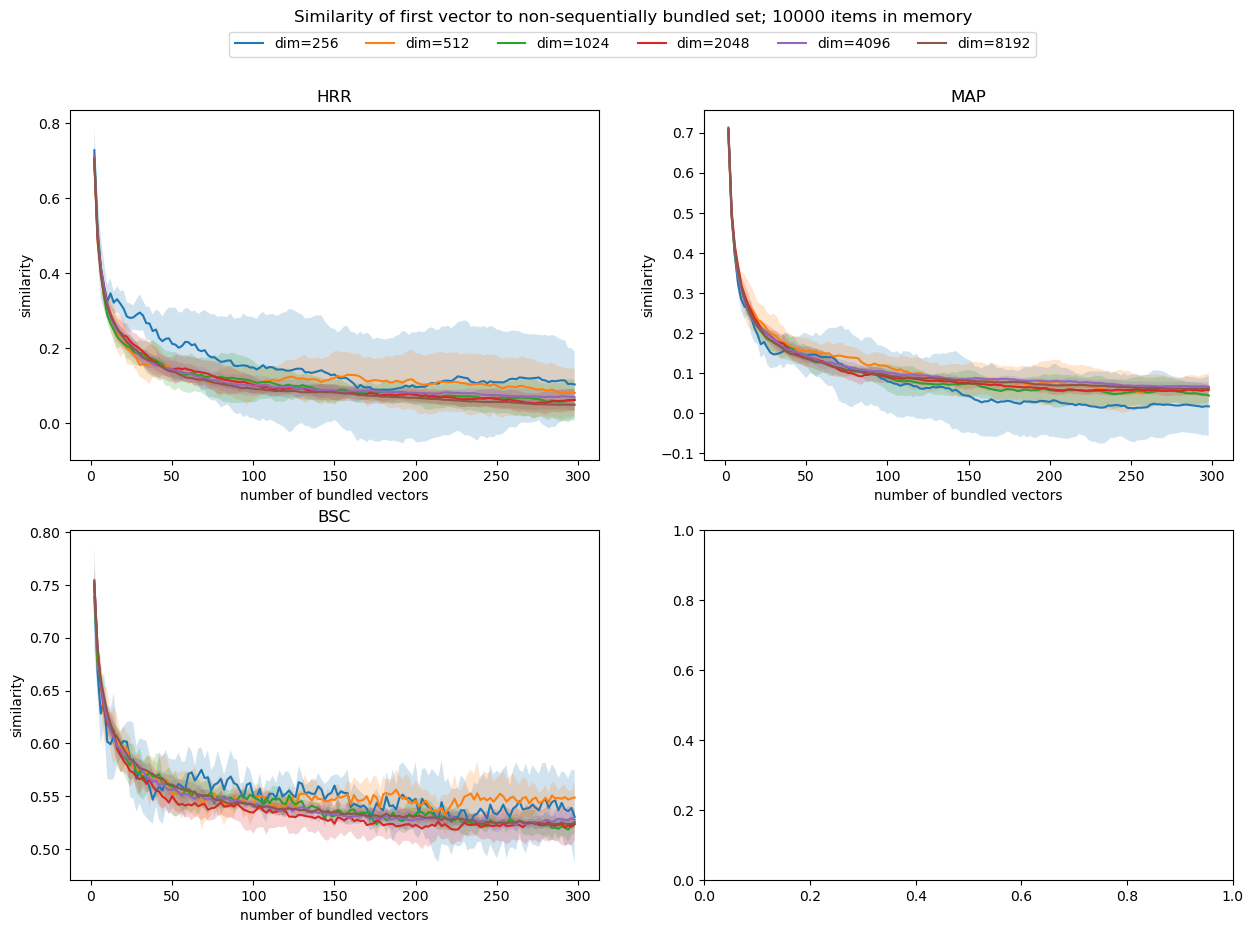

In [ ]:
# MAX_BUNDLE_SIZE_IDX = 10

fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Similarity of first vector to non-sequentially bundled set; {item_memory_size} items in memory')
for vsa_type_idx in range(len(VSA_TYPES)):
  vsa_type = VSA_TYPES[vsa_type_idx]
  row = (vsa_type_idx +1) // 2 - 1
  col = vsa_type_idx % 2
  ax[row, col].set_title(vsa_type)
  for dim_idx in range(len(DIMENSIONS)):
    ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}' if row == 0 and col == 0 else None, linestyle='-', color=f'C{dim_idx}')
    # ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], theoretical_prob_correct[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'theoretical for dim={DIMENSIONS[dim_idx]}', linestyle='--', color=f'C{dim_idx}')
    ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - sim_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + sim_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
  ax[row, col].set_xlabel('number of bundled vectors')
  ax[row, col].set_ylabel('similarity')

# Create a single legend for the top plot
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .965))

plt.show()
    

### Results

We notice that the non-normalized similiarity to the first (or a random) vector seems to be independent of the dimensionality.

Thus we have a higher similarity to the first vector in the beginning because we just have not bundled enough vectors yet. But after a certain amount of vectors, which seems to be the same for all dimensions, the similarity drops to a certain level and stays there; this level does seem to be slightly higher than the similarity to a random vector. Allowing us to still retrieve the first vector with a higher probability than a random vector.

The above can be explained by the fact that in lower dimensions the similarity to a random vector is higher than in higher dimensions. Thus while the similarity to the first (or random) vector moves independently of the dimensionality, the similarity to a random vector moves with the dimensionality, thus the capacity or probability of retrieving the first vector also moves with the dimensionality.

### Heatmaps for each vsa type

In [ ]:
# fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
# fig.suptitle(f'Similarity of first vector to non-sequentially bundled set; {item_memory_size} items in memory')

# for vsa_type_idx in range(len(VSA_TYPES)):
#     vsa_type = VSA_TYPES[vsa_type_idx]
#     row = (vsa_type_idx +1) // 2 - 1
#     col = vsa_type_idx % 2
#     ax[row, col].set_title(vsa_type)
#     ax[row, col] = sns.heatmap(sim_first_vector_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//20, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//20], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'similarity'})
#     ax[row, col].set_xlabel('number of bundled vectors')
#     ax[row, col].set_ylabel('dimensionality')
  

Why is this not a problem, and actually to be expected?

### Line plots for each vsa type

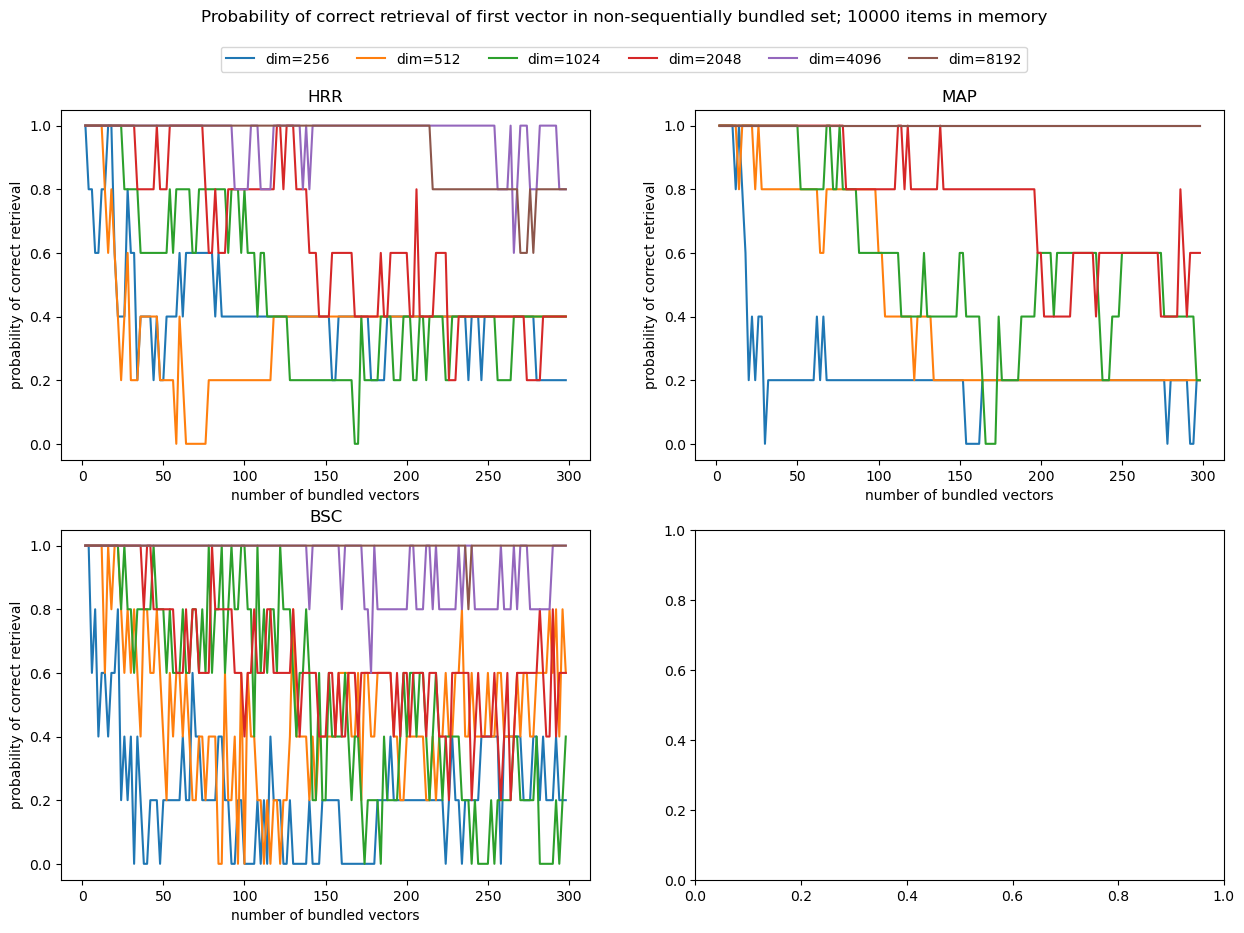

In [ ]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Probability of correct retrieval of first vector in non-sequentially bundled set; {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx +1) // 2 - 1
    col = vsa_type_idx % 2
    ax[row, col].set_title(vsa_type)
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], retrieval_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        # ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], retrieval_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - retrieval_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], retrieval_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + retrieval_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('probability of correct retrieval')
fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

### Results

The probability of correct retrieval of the first (or a random) vector depends on the dimensionality and the number of vectors bound. If we think logically this plot should be an approx. of the first plot of the capacity study. We also observe slightly higher stds for the lower dimensions.

### Heatmaps for each vsa type

In [ ]:
# fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
# fig.suptitle(f'Probability of correct retrieval of first vector in non-sequentially bundled set; {item_memory_size} items in memory')

# for vsa_type_idx in range(len(VSA_TYPES)):
#     vsa_type = VSA_TYPES[vsa_type_idx]
#     row = (vsa_type_idx +1) // 2 - 1
#     col = vsa_type_idx % 2
#     ax[row, col].set_title(vsa_type)
#     ax[row, col] = sns.heatmap(retrieval_first_vector_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//10, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//10], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'percentage of correct retrieval'})
#     ax[row, col].set_xlabel('number of bundled vectors')
#     ax[row, col].set_ylabel('dimensionality')

In [ ]:
vsa_type = 'MAP'
similarity_func = partial(similarity_func_partial, vsa_type)
dim = 2**13
bundle_size = 300

item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)
rand_perm = torch.randperm(item_memory_size)
random_indices_to_bundle = rand_perm[:bundle_size]
random_indices_not_bundled = rand_perm[bundle_size:]
experiment_to_bundle_vectors = item_memory[random_indices_to_bundle]
experiment_not_to_bundle_vectors = item_memory[random_indices_not_bundled]

bundle_vector = torchhd.multiset(experiment_to_bundle_vectors)
similarity_to_bundle = similarity_func(bundle_vector, experiment_to_bundle_vectors)
similarity_to_not_bundle = similarity_func(bundle_vector, experiment_not_to_bundle_vectors)



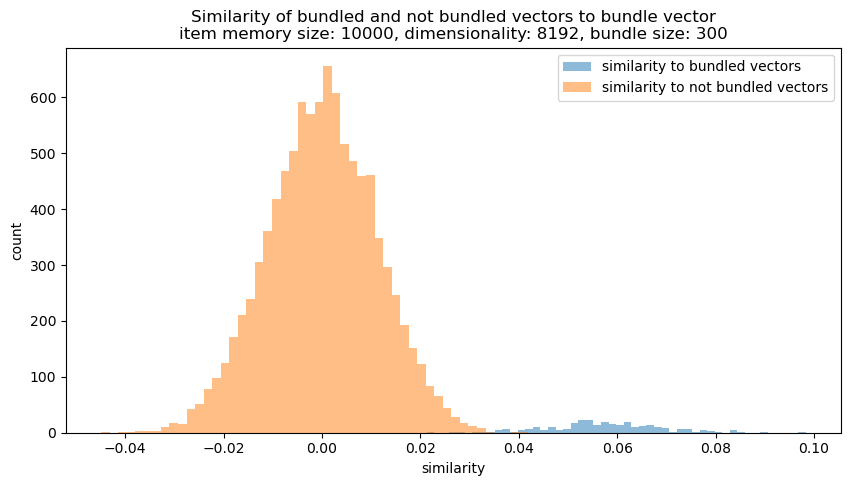

In [ ]:
# plot similarity to bundle and not bundled vectors
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.hist(similarity_to_bundle.cpu().numpy(), bins=50, alpha=0.5, label='similarity to bundled vectors')
ax.hist(similarity_to_not_bundle.cpu().numpy(), bins=50, alpha=0.5, label='similarity to not bundled vectors')
ax.set_title(f'Similarity of bundled and not bundled vectors to bundle vector\nitem memory size: {item_memory_size}, dimensionality: {dim}, bundle size: {bundle_size}')
ax.set_xlabel('similarity')
ax.set_ylabel('count')
ax.legend()

